In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr, ttest_ind
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load and Prepare Data

In [3]:
# Load all datasets
fighter_attributes = pd.read_csv('data/fighter_attributes.csv')
fighter_history = pd.read_csv('data/fighter_history.csv')
fighter_stats = pd.read_csv('data/fighter_stats.csv')

print(f"Fighter Attributes: {fighter_attributes.shape[0]:,} fighters")
print(f"Fighter History: {fighter_history.shape[0]:,} fight records")
print(f"Fighter Stats: {fighter_stats.shape[0]:,} stat records")

Fighter Attributes: 3,035 fighters
Fighter History: 17,837 fight records
Fighter Stats: 34,586 stat records


In [4]:
# Calculate Reach-to-Height Ratio
fighter_attributes['reach_height_ratio'] = fighter_attributes['reach'] / fighter_attributes['height']

# Check for valid ratio values
valid_ratio = fighter_attributes['reach_height_ratio'].notna()
print(f"Fighters with valid reach/height ratio: {valid_ratio.sum():,} out of {len(fighter_attributes):,}")
print(f"\nReach/Height Ratio Statistics:")
print(fighter_attributes['reach_height_ratio'].describe())

Fighters with valid reach/height ratio: 2,456 out of 3,035

Reach/Height Ratio Statistics:
count    2456.000000
mean        1.024554
std         0.028634
min         0.905405
25%         1.000000
50%         1.026667
75%         1.043478
max         1.136364
Name: reach_height_ratio, dtype: float64


In [5]:
# Calculate win/loss records for each fighter
fighter_records = fighter_history.groupby('fighter_id').agg({
    'fight_result': [
        lambda x: (x == 'W').sum(),  # wins
        lambda x: (x == 'L').sum(),  # losses
        'count'  # total fights
    ],
    'fighter_name': 'first'
})

fighter_records.columns = ['wins', 'losses', 'total_fights', 'fighter_name']
fighter_records['win_rate'] = fighter_records['wins'] / fighter_records['total_fights']
fighter_records = fighter_records.reset_index()

print(f"Fighters with fight records: {len(fighter_records):,}")
fighter_records.head()

Fighters with fight records: 3,015


,fighter_id,wins,losses,total_fights,fighter_name,win_rate
0,2220951,6,5,12,greg hardy,0.500000
1,2223033,2,5,8,austen lane,0.250000
2,2312150,5,2,7,mohammed usman,0.714286
3,2335243,9,10,19,carlos condit,0.473684
4,2335256,1,3,4,carmelo marrero,0.250000


In [6]:
# Aggregate fighter statistics
fighter_agg_stats = fighter_stats.groupby('fighter_id').agg({
    # Strikes landed/absorbed
    'TSL': 'sum',  # Total strikes landed
    'TSA': 'sum',  # Total strikes attempted
    'SSL': 'sum',  # Significant strikes landed
    'SSA': 'sum',  # Significant strikes attempted
    # Strikes absorbed (clinch + ground)
    'SCBA': 'sum',  # Strikes to body absorbed (clinch)
    'SCHA': 'sum',  # Strikes to head absorbed (clinch)
    'SGBA': 'sum',  # Strikes to body absorbed (ground)
    'SGHA': 'sum',  # Strikes to head absorbed (ground)
    # Distance strikes (absorbed)
    'SDBA': 'sum',  # Strikes to body absorbed at distance
    'SDHA': 'sum',  # Strikes to head absorbed at distance
    'SDLA': 'sum',  # Strikes to leg absorbed at distance
    # Knockdowns
    'KD': 'sum',
    # Takedowns
    'TDL': 'sum',
    'TDA': 'sum'
}).reset_index()

# Calculate derived metrics
fighter_agg_stats['total_strikes_absorbed'] = (fighter_agg_stats['SDBA'] + fighter_agg_stats['SDHA'] + 
                                               fighter_agg_stats['SDLA'] + fighter_agg_stats['SCBA'] + 
                                               fighter_agg_stats['SCHA'] + fighter_agg_stats['SGBA'] + 
                                               fighter_agg_stats['SGHA'])
fighter_agg_stats['strike_accuracy'] = fighter_agg_stats['SSL'] / fighter_agg_stats['SSA']
fighter_agg_stats['takedown_accuracy'] = fighter_agg_stats['TDL'] / fighter_agg_stats['TDA']

fighter_agg_stats.head()

,fighter_id,TSL,TSA,SSL,SSA,SCBA,SCHA,SGBA,SGHA,SDBA,SDHA,SDLA,KD,TDL,TDA,total_strikes_absorbed,strike_accuracy,takedown_accuracy
0,2220951,398,757,363,721,4,13,3,89,68,433,111,3,1,3,721,0.503467,0.333333
1,2223033,199,342,108,212,2,3,3,45,33,103,23,1,4,14,212,0.509434,0.285714
2,2312150,416,940,310,791,3,8,0,10,173,593,4,1,3,21,791,0.391909,0.142857
3,2335243,1723,3316,969,2496,40,119,8,165,278,1583,297,6,9,22,2490,0.388221,0.409091
4,2335256,97,157,27,83,2,3,10,22,2,39,5,0,6,15,83,0.325301,0.400000


In [7]:
# Merge all data together
df = fighter_attributes.merge(fighter_records, on='fighter_id', how='inner')
df = df.merge(fighter_agg_stats, on='fighter_id', how='left')

# Filter for fighters with valid reach/height ratio and minimum fights
MIN_FIGHTS = 3
df_analysis = df[(df['reach_height_ratio'].notna()) & (df['total_fights'] >= MIN_FIGHTS)].copy()

print(f"Fighters for analysis (min {MIN_FIGHTS} fights, valid ratio): {len(df_analysis):,}")
print(f"\nColumns available: {list(df_analysis.columns)}")

Fighters for analysis (min 3 fights, valid ratio): 1,797

Columns available: ['fighter_id', 'name', 'height', 'weight', 'age', 'dob', 'gender', 'weight_class', 'reach', 'stance', 'style', 'gym', 'country', 'reach_height_ratio', 'wins', 'losses', 'total_fights', 'fighter_name', 'win_rate', 'TSL', 'TSA', 'SSL', 'SSA', 'SCBA', 'SCHA', 'SGBA', 'SGHA', 'SDBA', 'SDHA', 'SDLA', 'KD', 'TDL', 'TDA', 'total_strikes_absorbed', 'strike_accuracy', 'takedown_accuracy']


## 2. Reach-to-Height Ratio Distribution

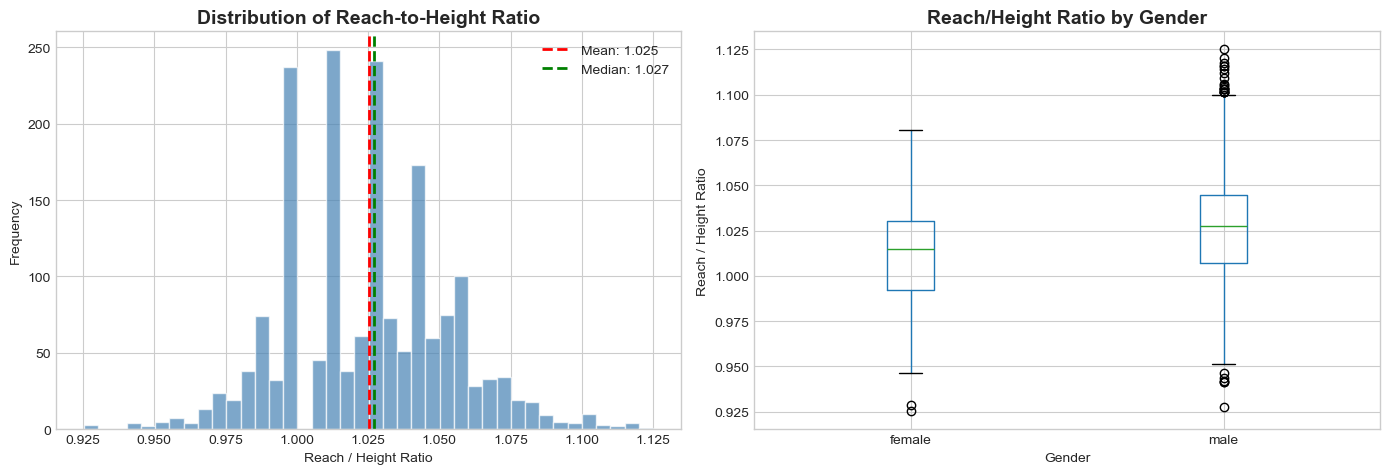


Interpretation: A ratio of 1.0 means reach equals height.
Ratios > 1.0 indicate fighters with longer arms relative to their height.


In [8]:
# Distribution of reach/height ratio
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_analysis['reach_height_ratio'], bins=40, color='steelblue', edgecolor='white', alpha=0.7)
mean_ratio = df_analysis['reach_height_ratio'].mean()
median_ratio = df_analysis['reach_height_ratio'].median()
axes[0].axvline(mean_ratio, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_ratio:.3f}')
axes[0].axvline(median_ratio, color='green', linestyle='--', linewidth=2, label=f'Median: {median_ratio:.3f}')
axes[0].set_title('Distribution of Reach-to-Height Ratio', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Reach / Height Ratio')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Box plot by gender
df_analysis.boxplot(column='reach_height_ratio', by='gender', ax=axes[1])
axes[1].set_title('Reach/Height Ratio by Gender', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Reach / Height Ratio')
plt.suptitle('')

plt.tight_layout()
plt.show()

print(f"\nInterpretation: A ratio of 1.0 means reach equals height.")
print(f"Ratios > 1.0 indicate fighters with longer arms relative to their height.")

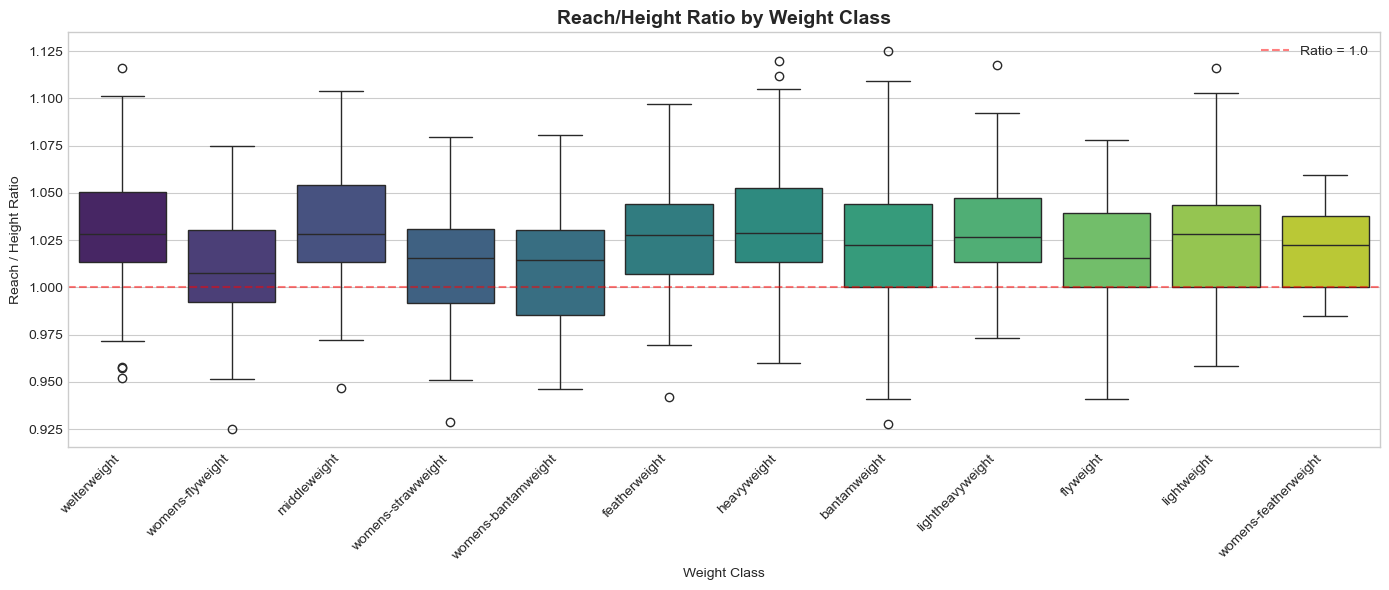

In [9]:
# Distribution by weight class
plt.figure(figsize=(14, 6))
weight_classes = df_analysis['weight_class'].value_counts().head(12).index
df_wc = df_analysis[df_analysis['weight_class'].isin(weight_classes)]

sns.boxplot(data=df_wc, x='weight_class', y='reach_height_ratio', palette='viridis')
plt.axhline(1.0, color='red', linestyle='--', alpha=0.5, label='Ratio = 1.0')
plt.title('Reach/Height Ratio by Weight Class', fontsize=14, fontweight='bold')
plt.xlabel('Weight Class')
plt.ylabel('Reach / Height Ratio')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

## 3. Reach/Height Ratio vs Win Rate - Core Hypothesis Test

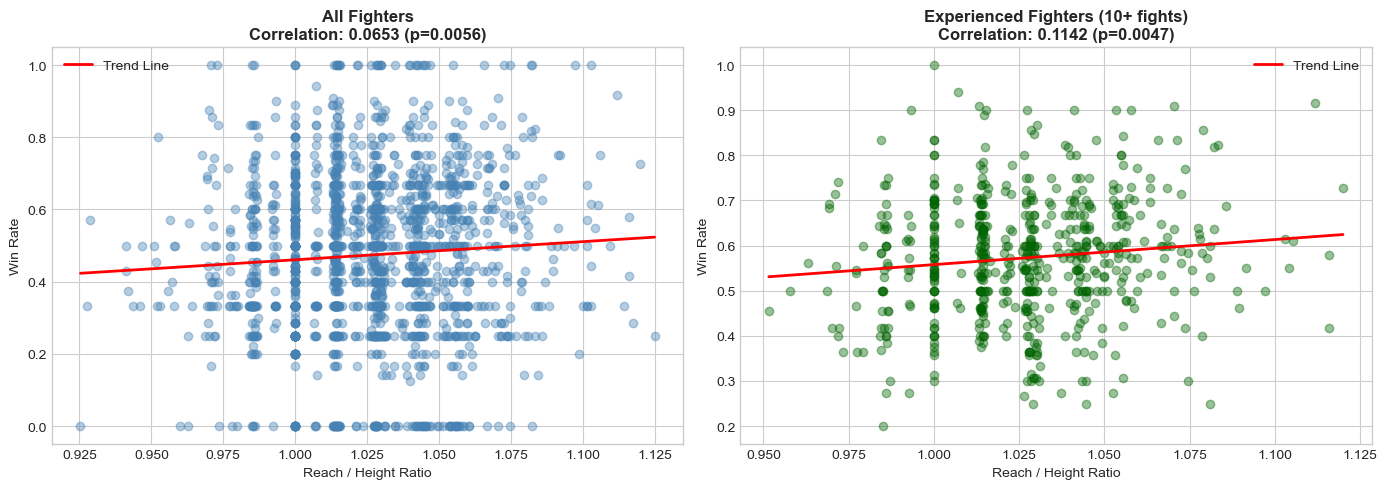

In [10]:
# Scatter plot: Reach/Height Ratio vs Win Rate
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# All fighters
axes[0].scatter(df_analysis['reach_height_ratio'], df_analysis['win_rate'], alpha=0.4, c='steelblue')

# Add trend line
z = np.polyfit(df_analysis['reach_height_ratio'], df_analysis['win_rate'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_analysis['reach_height_ratio'].min(), df_analysis['reach_height_ratio'].max(), 100)
axes[0].plot(x_line, p(x_line), 'r-', linewidth=2, label='Trend Line')

# Calculate correlation
corr, p_value = pearsonr(df_analysis['reach_height_ratio'], df_analysis['win_rate'])
axes[0].set_title(f'All Fighters\nCorrelation: {corr:.4f} (p={p_value:.4f})', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Reach / Height Ratio')
axes[0].set_ylabel('Win Rate')
axes[0].legend()

# Fighters with more fights (minimum 10)
df_exp = df_analysis[df_analysis['total_fights'] >= 10]
axes[1].scatter(df_exp['reach_height_ratio'], df_exp['win_rate'], alpha=0.4, c='darkgreen')

z2 = np.polyfit(df_exp['reach_height_ratio'], df_exp['win_rate'], 1)
p2 = np.poly1d(z2)
x_line2 = np.linspace(df_exp['reach_height_ratio'].min(), df_exp['reach_height_ratio'].max(), 100)
axes[1].plot(x_line2, p2(x_line2), 'r-', linewidth=2, label='Trend Line')

corr2, p_value2 = pearsonr(df_exp['reach_height_ratio'], df_exp['win_rate'])
axes[1].set_title(f'Experienced Fighters (10+ fights)\nCorrelation: {corr2:.4f} (p={p_value2:.4f})', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Reach / Height Ratio')
axes[1].set_ylabel('Win Rate')
axes[1].legend()

plt.tight_layout()
plt.show()

In [11]:
# Create reach/height ratio categories (quintiles)
df_analysis['ratio_quintile'] = pd.qcut(df_analysis['reach_height_ratio'], q=5, 
                                        labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Compare win rates across quintiles
quintile_stats = df_analysis.groupby('ratio_quintile').agg({
    'win_rate': ['mean', 'std', 'count'],
    'reach_height_ratio': ['min', 'max', 'mean']
}).round(4)

print("Win Rate Statistics by Reach/Height Ratio Quintile:")
print("="*70)
quintile_stats

Win Rate Statistics by Reach/Height Ratio Quintile:


win_rate               reach_height_ratio                
                   mean     std count                min     max    mean
ratio_quintile                                                          
Very Low         0.4453  0.2063   462             0.9254  1.0000  0.9901
Low              0.4872  0.2177   276             1.0064  1.0149  1.0130
Medium           0.4868  0.2171   357             1.0152  1.0299  1.0252
High             0.4719  0.2288   343             1.0303  1.0486  1.0404
Very High        0.4871  0.2282   359             1.0492  1.1250  1.0659

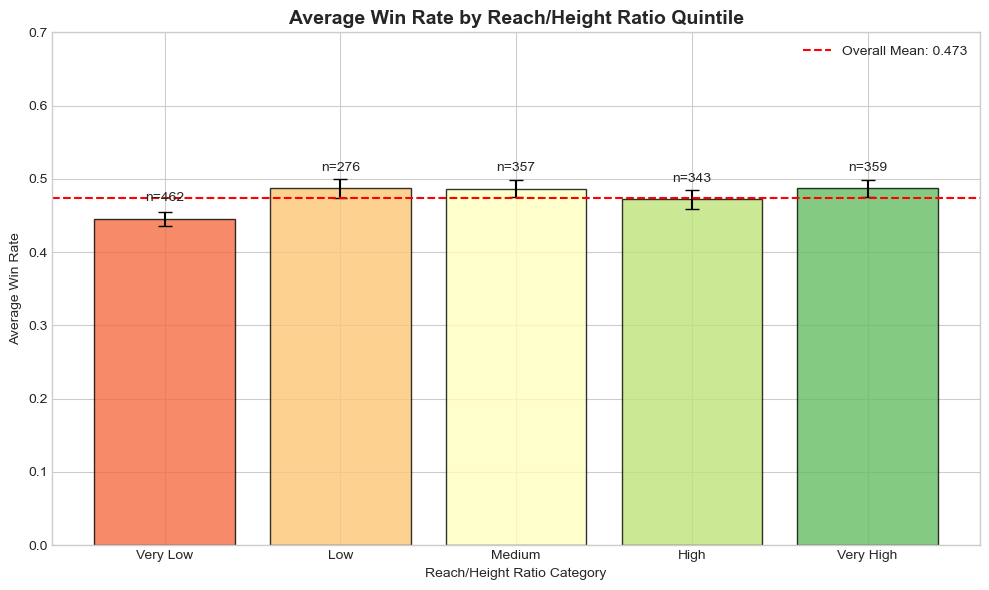

In [12]:
# Bar plot of win rate by quintile
fig, ax = plt.subplots(figsize=(10, 6))

quintile_means = df_analysis.groupby('ratio_quintile')['win_rate'].mean()
quintile_std = df_analysis.groupby('ratio_quintile')['win_rate'].std()
quintile_counts = df_analysis.groupby('ratio_quintile')['win_rate'].count()

colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, 5))
bars = ax.bar(quintile_means.index, quintile_means.values, yerr=quintile_std.values/np.sqrt(quintile_counts.values),
              capsize=5, color=colors, edgecolor='black', alpha=0.8)

# Add count labels
for bar, count in zip(bars, quintile_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'n={count}', ha='center', va='bottom', fontsize=10)

ax.set_title('Average Win Rate by Reach/Height Ratio Quintile', fontsize=14, fontweight='bold')
ax.set_xlabel('Reach/Height Ratio Category')
ax.set_ylabel('Average Win Rate')
ax.set_ylim(0, 0.7)
ax.axhline(df_analysis['win_rate'].mean(), color='red', linestyle='--', label=f'Overall Mean: {df_analysis["win_rate"].mean():.3f}')
ax.legend()

plt.tight_layout()
plt.show()

In [13]:
# Statistical test: Compare top vs bottom quintile
very_high = df_analysis[df_analysis['ratio_quintile'] == 'Very High']['win_rate']
very_low = df_analysis[df_analysis['ratio_quintile'] == 'Very Low']['win_rate']

t_stat, t_pvalue = ttest_ind(very_high, very_low)

print("T-Test: Very High vs Very Low Reach/Height Ratio Fighters")
print("="*60)
print(f"Very High Ratio - Mean Win Rate: {very_high.mean():.4f} (n={len(very_high)})")
print(f"Very Low Ratio - Mean Win Rate: {very_low.mean():.4f} (n={len(very_low)})")
print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {t_pvalue:.4f}")
print(f"\nStatistically significant at α=0.05? {'Yes' if t_pvalue < 0.05 else 'No'}")

T-Test: Very High vs Very Low Reach/Height Ratio Fighters
Very High Ratio - Mean Win Rate: 0.4871 (n=359)
Very Low Ratio - Mean Win Rate: 0.4453 (n=462)

T-statistic: 2.7453
P-value: 0.0062

Statistically significant at α=0.05? Yes


## 4. Analysis by Stance

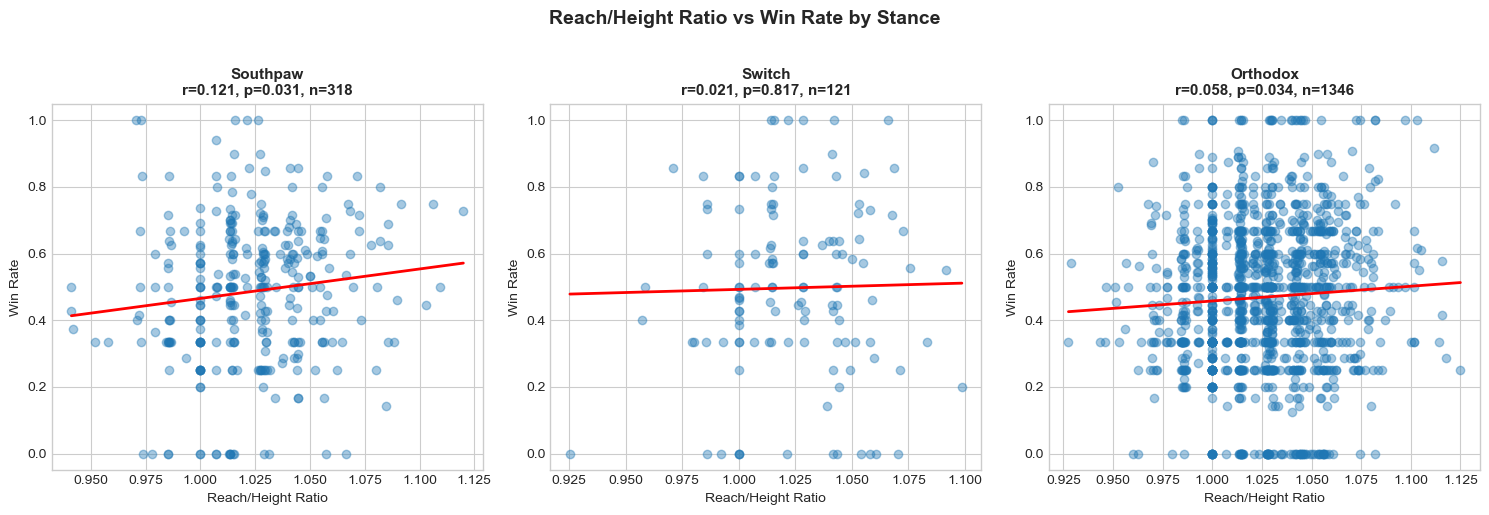

In [14]:
# Reach/Height ratio vs Win Rate by Stance
stances = df_analysis['stance'].dropna().unique()
valid_stances = df_analysis.groupby('stance').filter(lambda x: len(x) >= 30)['stance'].unique()

fig, axes = plt.subplots(1, len(valid_stances), figsize=(5*len(valid_stances), 5))
if len(valid_stances) == 1:
    axes = [axes]

stance_correlations = {}

for ax, stance in zip(axes, valid_stances):
    df_stance = df_analysis[df_analysis['stance'] == stance]
    
    ax.scatter(df_stance['reach_height_ratio'], df_stance['win_rate'], alpha=0.4)
    
    # Trend line
    z = np.polyfit(df_stance['reach_height_ratio'], df_stance['win_rate'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df_stance['reach_height_ratio'].min(), df_stance['reach_height_ratio'].max(), 100)
    ax.plot(x_line, p(x_line), 'r-', linewidth=2)
    
    # Correlation
    corr, pval = pearsonr(df_stance['reach_height_ratio'], df_stance['win_rate'])
    stance_correlations[stance] = {'corr': corr, 'p_value': pval, 'n': len(df_stance)}
    
    ax.set_title(f'{stance.title()}\nr={corr:.3f}, p={pval:.3f}, n={len(df_stance)}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Reach/Height Ratio')
    ax.set_ylabel('Win Rate')

plt.suptitle('Reach/Height Ratio vs Win Rate by Stance', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [15]:
# Summary table for stance correlations
stance_df = pd.DataFrame(stance_correlations).T
stance_df = stance_df.sort_values('corr', ascending=False)
print("Correlation between Reach/Height Ratio and Win Rate by Stance:")
print("="*60)
stance_df

Correlation between Reach/Height Ratio and Win Rate by Stance:


,corr,p_value,n
southpaw,0.120931,0.031089,318.0
orthodox,0.057724,0.034213,1346.0
switch,0.021220,0.817296,121.0


## 5. Analysis for Strikers (Testing the Protection Hypothesis)

In [16]:
# Identify strikers by style
striker_styles = ['striker', 'muay thai', 'boxing', 'kickboxer', 'karate']
df_analysis['is_striker'] = df_analysis['style'].str.lower().isin(striker_styles)

print(f"Strikers identified: {df_analysis['is_striker'].sum()}")
print(f"Non-strikers: {(~df_analysis['is_striker']).sum()}")

Strikers identified: 552
Non-strikers: 1245


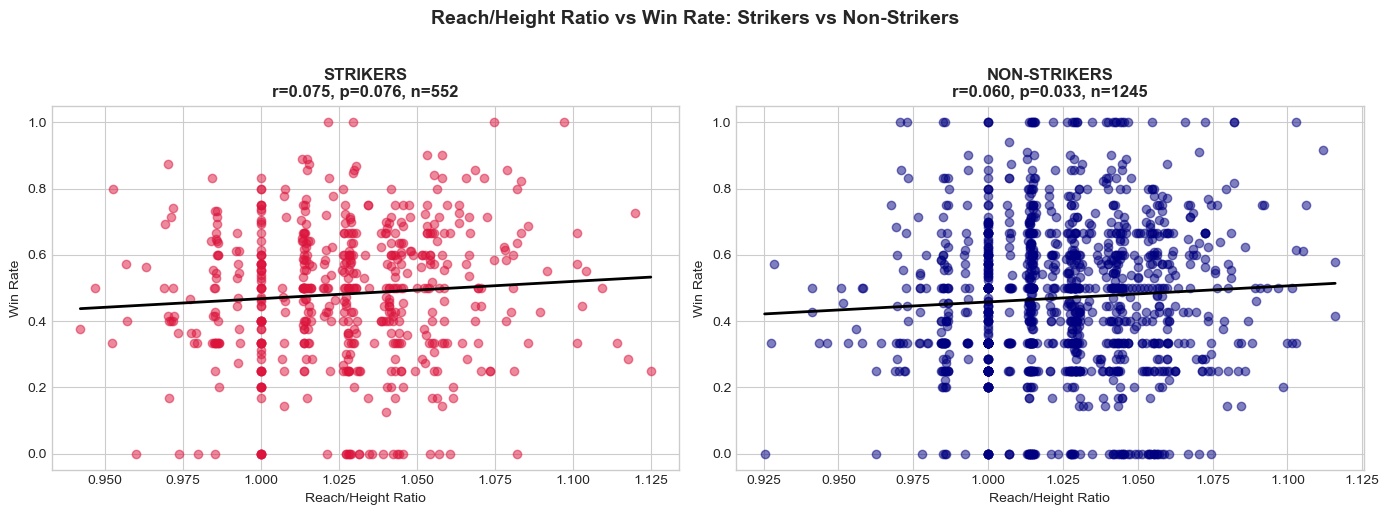

In [17]:
# Compare strikers vs non-strikers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Strikers
df_strikers = df_analysis[df_analysis['is_striker'] == True]
if len(df_strikers) >= 10:
    axes[0].scatter(df_strikers['reach_height_ratio'], df_strikers['win_rate'], alpha=0.5, c='crimson')
    z = np.polyfit(df_strikers['reach_height_ratio'], df_strikers['win_rate'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df_strikers['reach_height_ratio'].min(), df_strikers['reach_height_ratio'].max(), 100)
    axes[0].plot(x_line, p(x_line), 'k-', linewidth=2)
    
    corr_s, pval_s = pearsonr(df_strikers['reach_height_ratio'], df_strikers['win_rate'])
    axes[0].set_title(f'STRIKERS\nr={corr_s:.3f}, p={pval_s:.3f}, n={len(df_strikers)}', fontsize=12, fontweight='bold')
else:
    axes[0].text(0.5, 0.5, 'Insufficient striker data', ha='center', va='center', transform=axes[0].transAxes)
    axes[0].set_title('STRIKERS', fontsize=12, fontweight='bold')

axes[0].set_xlabel('Reach/Height Ratio')
axes[0].set_ylabel('Win Rate')

# Non-strikers
df_nonstrikers = df_analysis[df_analysis['is_striker'] == False]
axes[1].scatter(df_nonstrikers['reach_height_ratio'], df_nonstrikers['win_rate'], alpha=0.5, c='navy')
z2 = np.polyfit(df_nonstrikers['reach_height_ratio'], df_nonstrikers['win_rate'], 1)
p2 = np.poly1d(z2)
x_line2 = np.linspace(df_nonstrikers['reach_height_ratio'].min(), df_nonstrikers['reach_height_ratio'].max(), 100)
axes[1].plot(x_line2, p2(x_line2), 'k-', linewidth=2)

corr_ns, pval_ns = pearsonr(df_nonstrikers['reach_height_ratio'], df_nonstrikers['win_rate'])
axes[1].set_title(f'NON-STRIKERS\nr={corr_ns:.3f}, p={pval_ns:.3f}, n={len(df_nonstrikers)}', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Reach/Height Ratio')
axes[1].set_ylabel('Win Rate')

plt.suptitle('Reach/Height Ratio vs Win Rate: Strikers vs Non-Strikers', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [18]:
# All fighting styles breakdown
style_analysis = df_analysis.groupby('style').apply(
    lambda x: pd.Series({
        'n': len(x),
        'mean_ratio': x['reach_height_ratio'].mean(),
        'mean_win_rate': x['win_rate'].mean(),
        'correlation': pearsonr(x['reach_height_ratio'], x['win_rate'])[0] if len(x) >= 10 else np.nan,
        'p_value': pearsonr(x['reach_height_ratio'], x['win_rate'])[1] if len(x) >= 10 else np.nan
    })
).dropna()

style_analysis = style_analysis[style_analysis['n'] >= 20].sort_values('correlation', ascending=False)

print("Reach/Height Ratio vs Win Rate Correlation by Fighting Style:")
print("(Minimum 20 fighters per style)")
print("="*70)
style_analysis.round(4)

Reach/Height Ratio vs Win Rate Correlation by Fighting Style:
(Minimum 20 fighters per style)


,n,mean_ratio,mean_win_rate,correlation,p_value
style,,,,,
boxing,26.0,1.0296,0.4934,0.2417,0.2342
jiu-jitsu,24.0,1.0136,0.5359,0.1994,0.3503
wrestling,110.0,1.0326,0.5754,0.1128,0.2405
striker,483.0,1.0268,0.4819,0.0818,0.0726
mixed martial artist,197.0,1.0264,0.5166,0.0696,0.3314
brazilian jiu-jitsu,306.0,1.0257,0.4745,0.0592,0.3022
freestyle,57.0,1.0238,0.5226,-0.0646,0.6330
muay thai,35.0,1.0259,0.4605,-0.2014,0.2461
kickboxing,26.0,1.0323,0.5504,-0.2755,0.1731


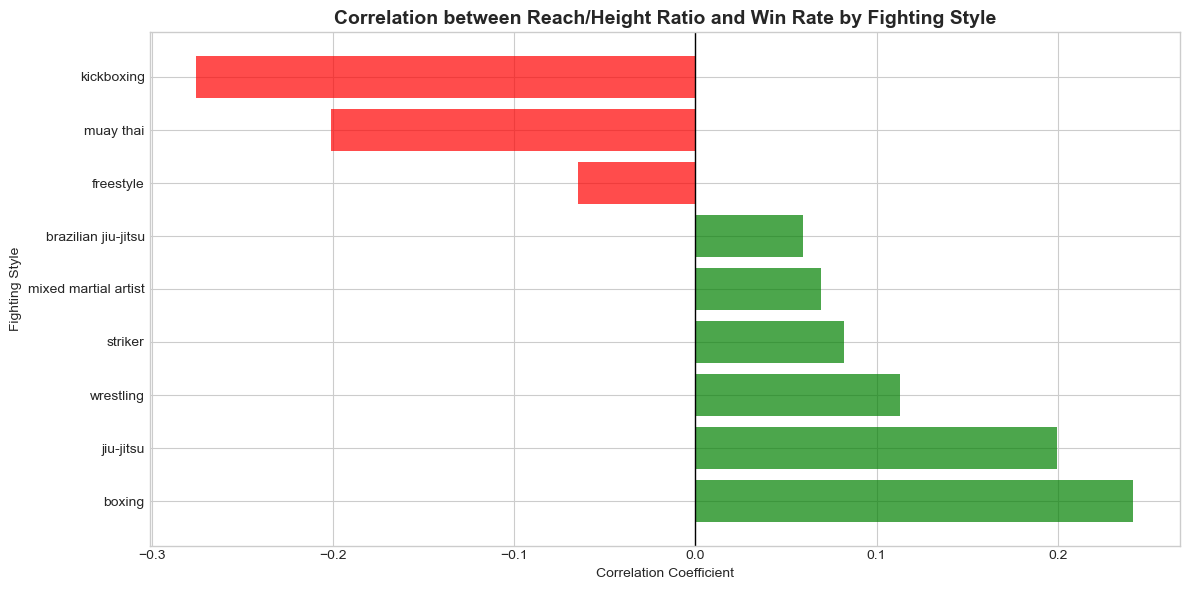

* indicates statistical significance at α=0.05


In [19]:
# Visualize style correlations
if len(style_analysis) > 0:
    plt.figure(figsize=(12, 6))
    colors = ['green' if x > 0 else 'red' for x in style_analysis['correlation']]
    bars = plt.barh(style_analysis.index, style_analysis['correlation'], color=colors, alpha=0.7)
    plt.axvline(0, color='black', linestyle='-', linewidth=1)
    plt.title('Correlation between Reach/Height Ratio and Win Rate by Fighting Style', fontsize=14, fontweight='bold')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Fighting Style')
    
    # Add significance markers
    for i, (idx, row) in enumerate(style_analysis.iterrows()):
        if row['p_value'] < 0.05:
            plt.text(row['correlation'] + 0.01 if row['correlation'] > 0 else row['correlation'] - 0.01, 
                     i, '*', fontsize=14, va='center', ha='left' if row['correlation'] > 0 else 'right')
    
    plt.tight_layout()
    plt.show()
    print("* indicates statistical significance at α=0.05")

## 6. Defensive Statistics Analysis (Strikes Absorbed)

In [20]:
# Calculate strikes absorbed per fight
df_analysis['strikes_absorbed_per_fight'] = df_analysis['total_strikes_absorbed'] / df_analysis['total_fights']

# Filter fighters with sufficient strike data
df_defense = df_analysis[df_analysis['total_strikes_absorbed'] > 0].copy()

print(f"Fighters with defensive stats: {len(df_defense):,}")

Fighters with defensive stats: 1,274


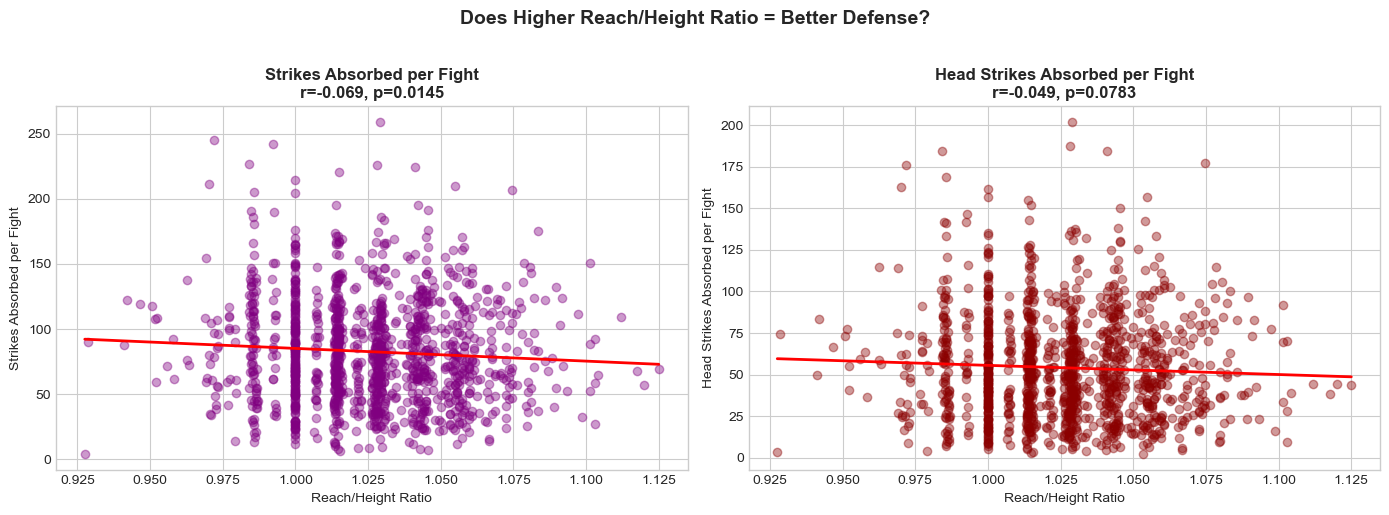


Hypothesis check: If longer arms provide better protection, we'd expect
NEGATIVE correlation (more reach ratio = fewer strikes absorbed).


In [21]:
# Reach/Height Ratio vs Strikes Absorbed per Fight
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total strikes absorbed per fight
axes[0].scatter(df_defense['reach_height_ratio'], df_defense['strikes_absorbed_per_fight'], alpha=0.4, c='purple')

z = np.polyfit(df_defense['reach_height_ratio'], df_defense['strikes_absorbed_per_fight'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_defense['reach_height_ratio'].min(), df_defense['reach_height_ratio'].max(), 100)
axes[0].plot(x_line, p(x_line), 'r-', linewidth=2)

corr, pval = pearsonr(df_defense['reach_height_ratio'], df_defense['strikes_absorbed_per_fight'])
axes[0].set_title(f'Strikes Absorbed per Fight\nr={corr:.3f}, p={pval:.4f}', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Reach/Height Ratio')
axes[0].set_ylabel('Strikes Absorbed per Fight')

# Head strikes absorbed specifically (SDHA)
df_defense['head_strikes_absorbed_per_fight'] = df_defense['SDHA'] / df_defense['total_fights']
axes[1].scatter(df_defense['reach_height_ratio'], df_defense['head_strikes_absorbed_per_fight'], alpha=0.4, c='darkred')

z2 = np.polyfit(df_defense['reach_height_ratio'], df_defense['head_strikes_absorbed_per_fight'], 1)
p2 = np.poly1d(z2)
x_line2 = np.linspace(df_defense['reach_height_ratio'].min(), df_defense['reach_height_ratio'].max(), 100)
axes[1].plot(x_line2, p2(x_line2), 'r-', linewidth=2)

corr2, pval2 = pearsonr(df_defense['reach_height_ratio'], df_defense['head_strikes_absorbed_per_fight'])
axes[1].set_title(f'Head Strikes Absorbed per Fight\nr={corr2:.3f}, p={pval2:.4f}', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Reach/Height Ratio')
axes[1].set_ylabel('Head Strikes Absorbed per Fight')

plt.suptitle('Does Higher Reach/Height Ratio = Better Defense?', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\nHypothesis check: If longer arms provide better protection, we'd expect")
print(f"NEGATIVE correlation (more reach ratio = fewer strikes absorbed).")

In [22]:
# Compare strikes absorbed by ratio quintile
df_defense['ratio_quintile'] = pd.qcut(df_defense['reach_height_ratio'], q=5, 
                                       labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

defense_by_quintile = df_defense.groupby('ratio_quintile').agg({
    'strikes_absorbed_per_fight': 'mean',
    'head_strikes_absorbed_per_fight': 'mean',
    'win_rate': 'mean',
    'fighter_id': 'count'
}).rename(columns={'fighter_id': 'count'})

print("Defensive Stats by Reach/Height Ratio Quintile:")
print("="*70)
defense_by_quintile.round(3)

Defensive Stats by Reach/Height Ratio Quintile:


,strikes_absorbed_per_fight,head_strikes_absorbed_per_fight,win_rate,count
ratio_quintile,,,,
Very Low,87.742,57.328,0.478,322
Low,84.100,54.765,0.522,196
Medium,78.802,50.625,0.523,257
High,82.636,55.704,0.499,244
Very High,78.908,51.820,0.511,255


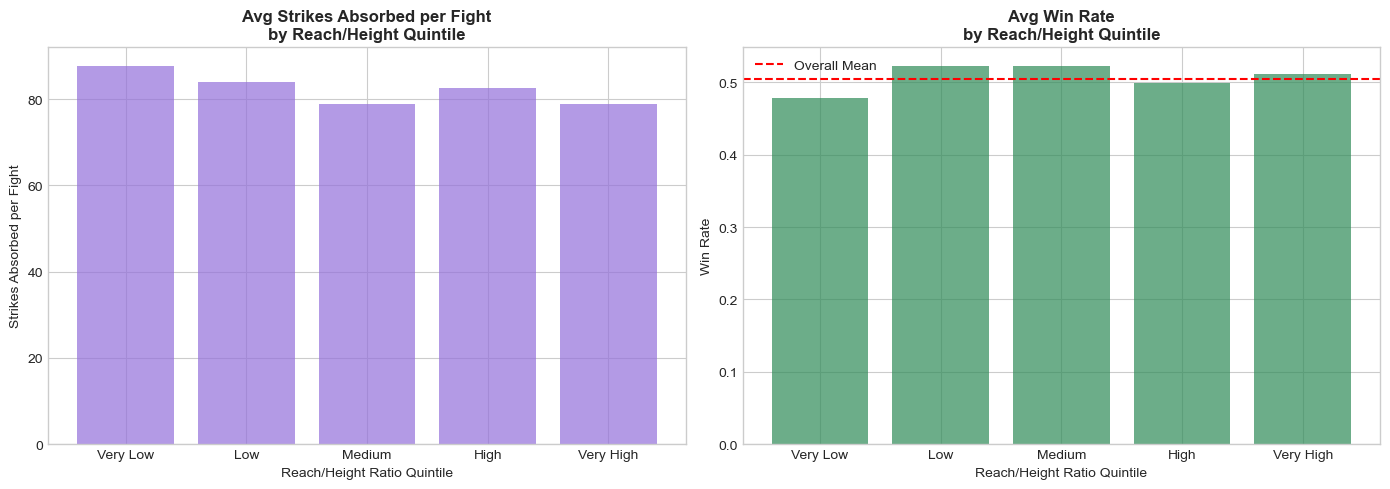

In [23]:
# Visualize defensive stats by quintile
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Strikes absorbed
quintile_labels = defense_by_quintile.index
axes[0].bar(quintile_labels, defense_by_quintile['strikes_absorbed_per_fight'], color='mediumpurple', alpha=0.7)
axes[0].set_title('Avg Strikes Absorbed per Fight\nby Reach/Height Quintile', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Reach/Height Ratio Quintile')
axes[0].set_ylabel('Strikes Absorbed per Fight')

# Win rate comparison
axes[1].bar(quintile_labels, defense_by_quintile['win_rate'], color='seagreen', alpha=0.7)
axes[1].set_title('Avg Win Rate\nby Reach/Height Quintile', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Reach/Height Ratio Quintile')
axes[1].set_ylabel('Win Rate')
axes[1].axhline(df_defense['win_rate'].mean(), color='red', linestyle='--', label='Overall Mean')
axes[1].legend()

plt.tight_layout()
plt.show()

## 7. Offensive Statistics Analysis

In [24]:
# Calculate offensive metrics per fight
df_analysis['sig_strikes_per_fight'] = df_analysis['SSL'] / df_analysis['total_fights']
df_analysis['knockdowns_per_fight'] = df_analysis['KD'] / df_analysis['total_fights']
df_analysis['takedowns_per_fight'] = df_analysis['TDL'] / df_analysis['total_fights']

# Filter for valid data
df_offense = df_analysis[df_analysis['SSL'] > 0].copy()

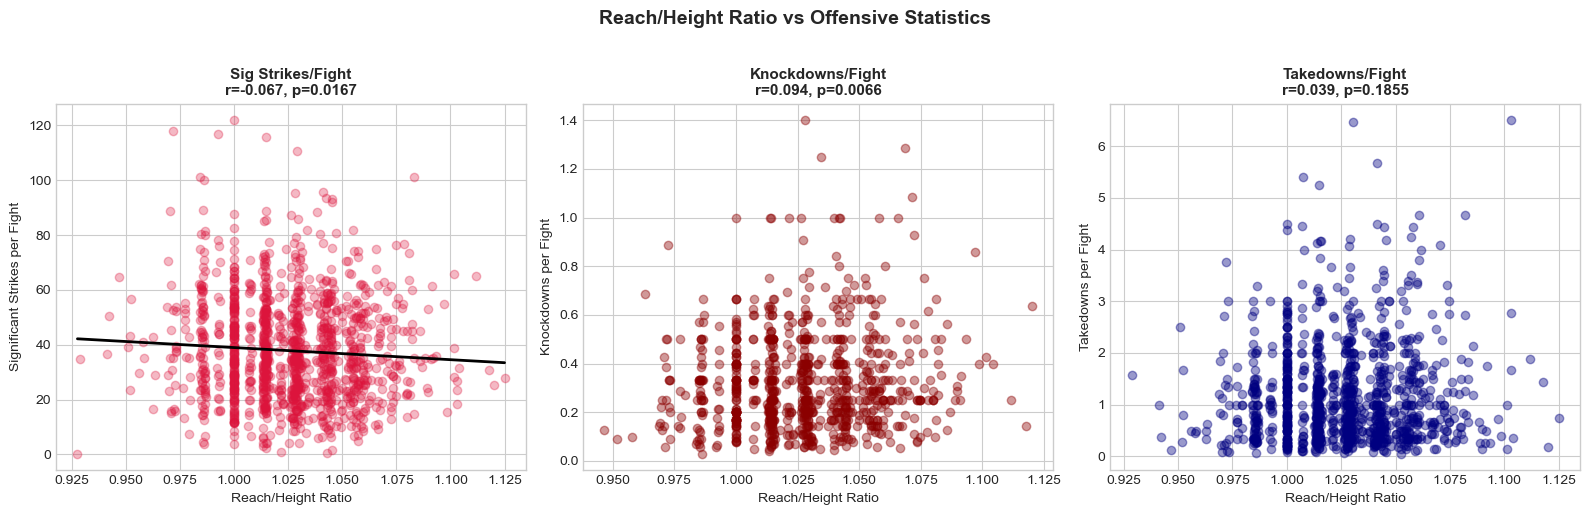

In [25]:
# Reach/Height Ratio vs Offensive Stats
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Significant strikes
axes[0].scatter(df_offense['reach_height_ratio'], df_offense['sig_strikes_per_fight'], alpha=0.3, c='crimson')
corr1, p1 = pearsonr(df_offense['reach_height_ratio'], df_offense['sig_strikes_per_fight'])
z = np.polyfit(df_offense['reach_height_ratio'], df_offense['sig_strikes_per_fight'], 1)
axes[0].plot(np.linspace(df_offense['reach_height_ratio'].min(), df_offense['reach_height_ratio'].max(), 100),
             np.poly1d(z)(np.linspace(df_offense['reach_height_ratio'].min(), df_offense['reach_height_ratio'].max(), 100)), 'k-', lw=2)
axes[0].set_title(f'Sig Strikes/Fight\nr={corr1:.3f}, p={p1:.4f}', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Reach/Height Ratio')
axes[0].set_ylabel('Significant Strikes per Fight')

# Knockdowns
df_kd = df_offense[df_offense['KD'] > 0]
axes[1].scatter(df_kd['reach_height_ratio'], df_kd['knockdowns_per_fight'], alpha=0.4, c='darkred')
corr2, p2 = pearsonr(df_kd['reach_height_ratio'], df_kd['knockdowns_per_fight'])
axes[1].set_title(f'Knockdowns/Fight\nr={corr2:.3f}, p={p2:.4f}', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Reach/Height Ratio')
axes[1].set_ylabel('Knockdowns per Fight')

# Takedowns
df_td = df_offense[df_offense['TDL'] > 0]
axes[2].scatter(df_td['reach_height_ratio'], df_td['takedowns_per_fight'], alpha=0.4, c='navy')
corr3, p3 = pearsonr(df_td['reach_height_ratio'], df_td['takedowns_per_fight'])
axes[2].set_title(f'Takedowns/Fight\nr={corr3:.3f}, p={p3:.4f}', fontsize=11, fontweight='bold')
axes[2].set_xlabel('Reach/Height Ratio')
axes[2].set_ylabel('Takedowns per Fight')

plt.suptitle('Reach/Height Ratio vs Offensive Statistics', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 8. Comprehensive Correlation Analysis

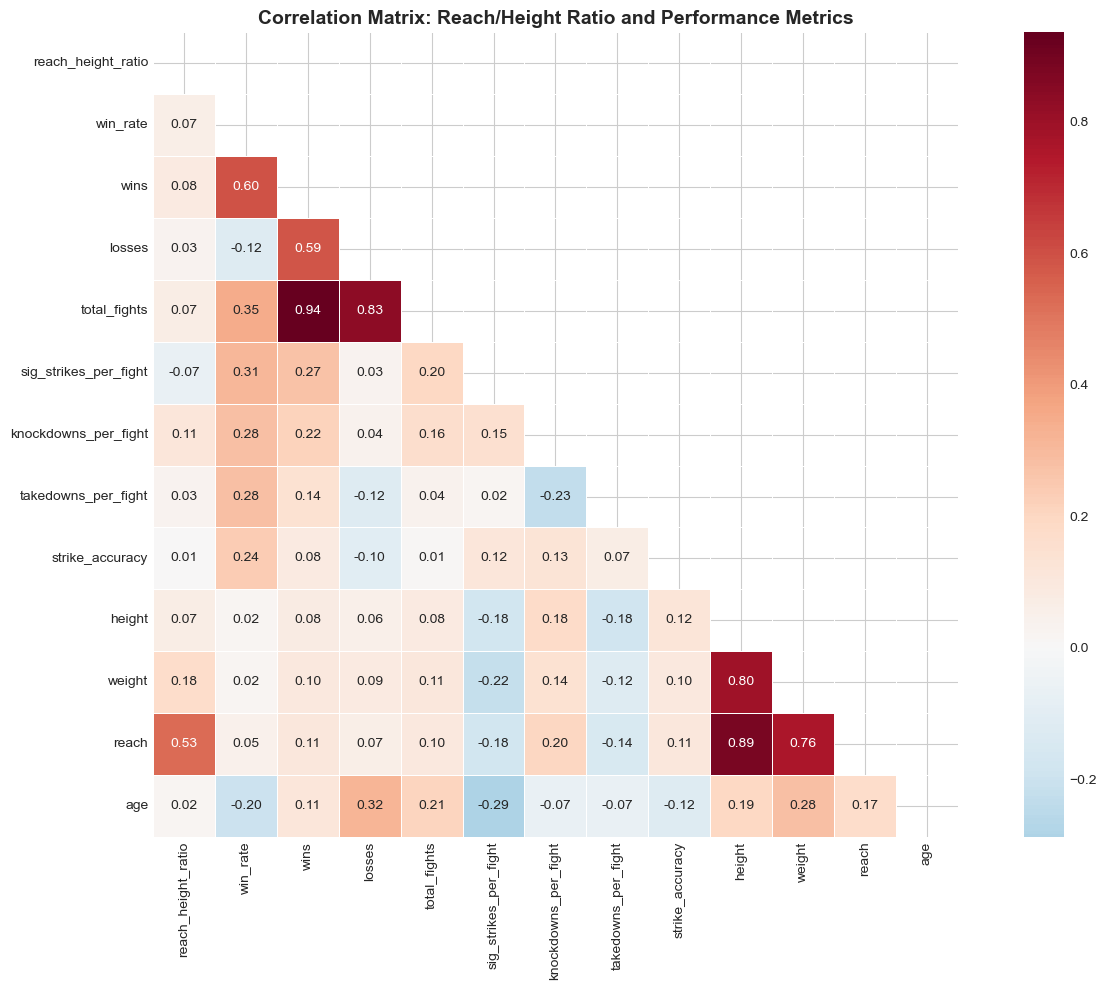

In [26]:
# Correlation matrix of key variables
corr_cols = ['reach_height_ratio', 'win_rate', 'wins', 'losses', 'total_fights',
             'sig_strikes_per_fight', 'knockdowns_per_fight', 'takedowns_per_fight',
             'strike_accuracy', 'height', 'weight', 'reach', 'age']

# Filter columns that exist
corr_cols = [c for c in corr_cols if c in df_analysis.columns]

corr_matrix = df_analysis[corr_cols].corr()

plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.2f',
            mask=mask, square=True, linewidths=0.5)
plt.title('Correlation Matrix: Reach/Height Ratio and Performance Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

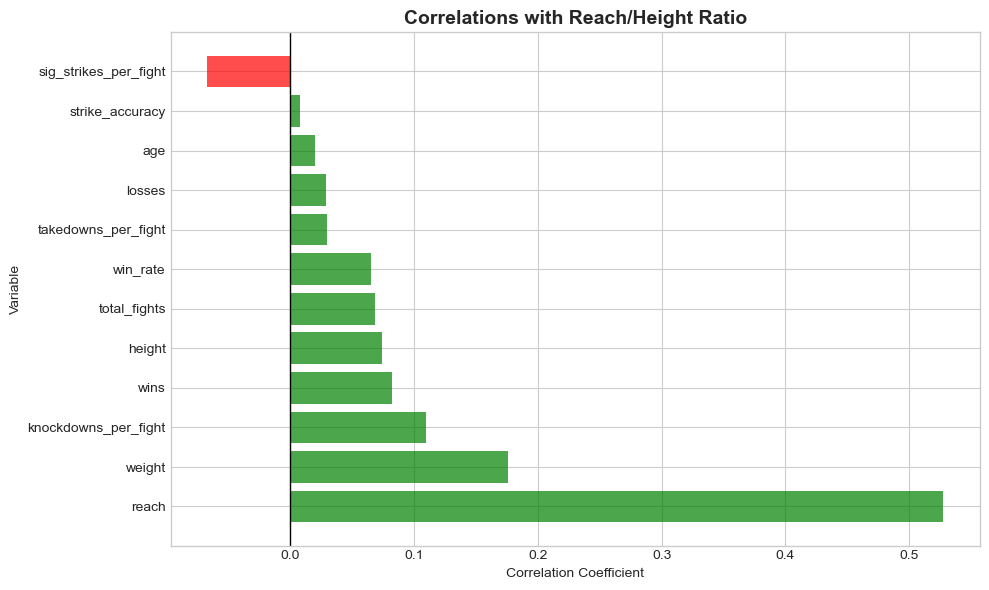

In [27]:
# Focus on correlations with reach/height ratio
ratio_correlations = corr_matrix['reach_height_ratio'].drop('reach_height_ratio').sort_values(ascending=False)

plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in ratio_correlations.values]
plt.barh(ratio_correlations.index, ratio_correlations.values, color=colors, alpha=0.7)
plt.axvline(0, color='black', linestyle='-', linewidth=1)
plt.title('Correlations with Reach/Height Ratio', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

## 9. Summary and Conclusions

In [28]:
# Calculate summary statistics
print("="*70)
print("REACH-TO-HEIGHT RATIO ANALYSIS: SUMMARY")
print("="*70)

# Overall correlation
overall_corr, overall_p = pearsonr(df_analysis['reach_height_ratio'], df_analysis['win_rate'])
print(f"\n1. OVERALL CORRELATION (Reach/Height Ratio vs Win Rate):")
print(f"   Correlation: {overall_corr:.4f}")
print(f"   P-value: {overall_p:.4f}")
print(f"   Sample size: {len(df_analysis):,} fighters")
print(f"   Interpretation: {'Weak' if abs(overall_corr) < 0.1 else 'Moderate' if abs(overall_corr) < 0.3 else 'Strong'} "
      f"{'positive' if overall_corr > 0 else 'negative'} correlation")

# Quintile comparison
print(f"\n2. QUINTILE COMPARISON:")
print(f"   Very Low Ratio Win Rate: {very_low.mean():.3f}")
print(f"   Very High Ratio Win Rate: {very_high.mean():.3f}")
print(f"   Difference: {very_high.mean() - very_low.mean():.3f}")
print(f"   T-test P-value: {t_pvalue:.4f}")

# Striker analysis
if len(df_strikers) >= 10:
    print(f"\n3. STRIKER-SPECIFIC ANALYSIS:")
    print(f"   Correlation for Strikers: {corr_s:.4f} (p={pval_s:.4f})")
    print(f"   Correlation for Non-Strikers: {corr_ns:.4f} (p={pval_ns:.4f})")

# Defensive stats
corr_def, pval_def = pearsonr(df_defense['reach_height_ratio'], df_defense['strikes_absorbed_per_fight'])
print(f"\n4. DEFENSIVE ANALYSIS:")
print(f"   Correlation with Strikes Absorbed: {corr_def:.4f} (p={pval_def:.4f})")
print(f"   (Negative = longer arms absorb fewer strikes)")

print("\n" + "="*70)
print("HYPOTHESIS EVALUATION:")
print("="*70)
print(f"\nOriginal Hypothesis: Higher reach/height ratio leads to better records")
print(f"because fighters can better protect themselves with longer arms.")
print(f"\nFinding: ", end="")

if overall_corr > 0.05 and overall_p < 0.05:
    print("SUPPORTED - There is a statistically significant positive correlation.")
elif overall_corr > 0 and overall_p >= 0.05:
    print("PARTIALLY SUPPORTED - Positive trend but not statistically significant.")
elif overall_corr < 0 and overall_p < 0.05:
    print("NOT SUPPORTED - Significant negative correlation found.")
else:
    print("INCONCLUSIVE - No clear relationship found.")

print("\n" + "="*70)

REACH-TO-HEIGHT RATIO ANALYSIS: SUMMARY

1. OVERALL CORRELATION (Reach/Height Ratio vs Win Rate):
   Correlation: 0.0653
   P-value: 0.0056
   Sample size: 1,797 fighters
   Interpretation: Weak positive correlation

2. QUINTILE COMPARISON:
   Very Low Ratio Win Rate: 0.445
   Very High Ratio Win Rate: 0.487
   Difference: 0.042
   T-test P-value: 0.0062

3. STRIKER-SPECIFIC ANALYSIS:
   Correlation for Strikers: 0.0755 (p=0.0765)
   Correlation for Non-Strikers: 0.0603 (p=0.0334)

4. DEFENSIVE ANALYSIS:
   Correlation with Strikes Absorbed: -0.0685 (p=0.0145)
   (Negative = longer arms absorb fewer strikes)

HYPOTHESIS EVALUATION:

Original Hypothesis: Higher reach/height ratio leads to better records
because fighters can better protect themselves with longer arms.

Finding: SUPPORTED - There is a statistically significant positive correlation.



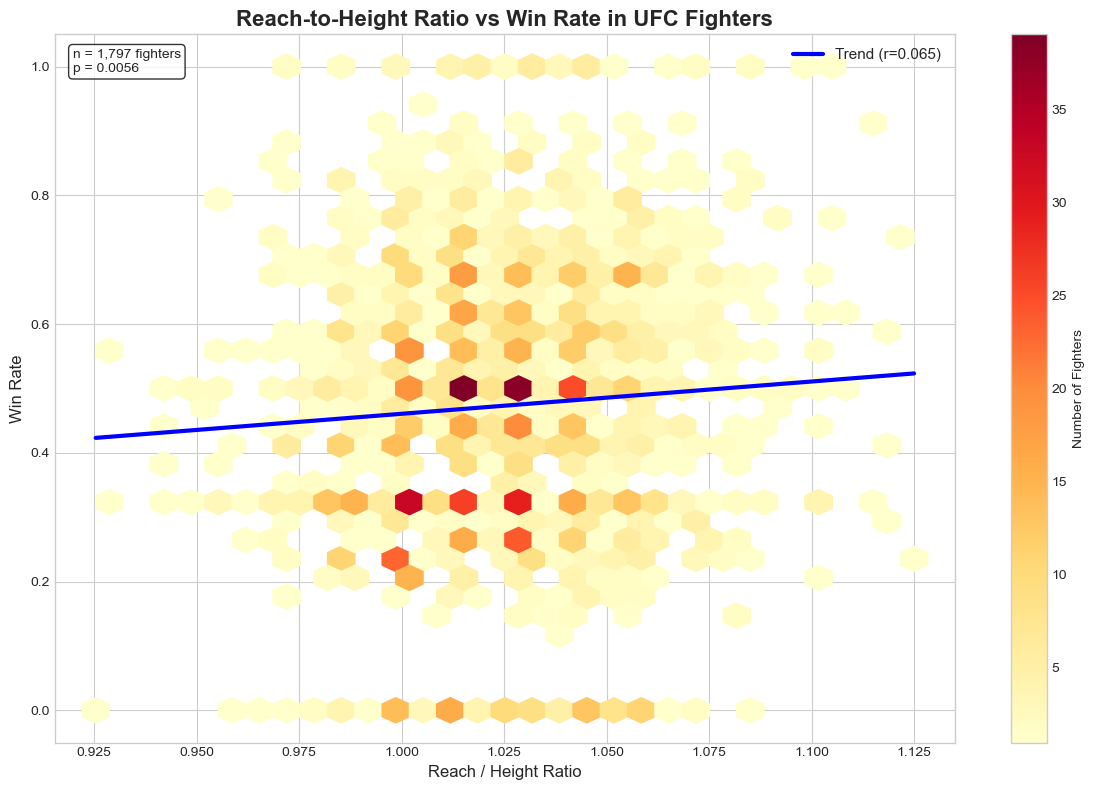

In [29]:
# Final visualization: The key finding
fig, ax = plt.subplots(figsize=(12, 8))

# Create hexbin plot for density visualization
hb = ax.hexbin(df_analysis['reach_height_ratio'], df_analysis['win_rate'], 
               gridsize=30, cmap='YlOrRd', mincnt=1)
cb = plt.colorbar(hb, label='Number of Fighters')

# Add trend line
z = np.polyfit(df_analysis['reach_height_ratio'], df_analysis['win_rate'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_analysis['reach_height_ratio'].min(), df_analysis['reach_height_ratio'].max(), 100)
ax.plot(x_line, p(x_line), 'b-', linewidth=3, label=f'Trend (r={overall_corr:.3f})')

ax.set_title('Reach-to-Height Ratio vs Win Rate in UFC Fighters', fontsize=16, fontweight='bold')
ax.set_xlabel('Reach / Height Ratio', fontsize=12)
ax.set_ylabel('Win Rate', fontsize=12)
ax.legend(loc='upper right', fontsize=11)

# Add annotation
ax.text(0.02, 0.98, f'n = {len(df_analysis):,} fighters\np = {overall_p:.4f}', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()